# 図形の検出

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
filename = 'data/level_1.jpg'

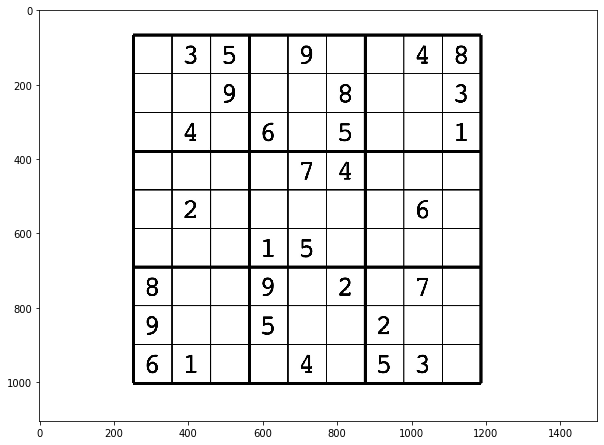

In [3]:
image = cv2.imread(filename, cv2.IMREAD_COLOR)
if image is None:
    raise Exception('Failed to load image file: ' + filename)
    
height, width, _ = image.shape
if max(height, width) >= 1500:
    scale = 1500 / max(height, width)
    image = cv2.resize(image, None, fx=scale, fy=scale)

height, width, _ = image.shape
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

## 数独の外枠を検出する

In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [5]:
binary_image = cv2.Canny(gray, 100, 200)
binary_image = cv2.dilate(binary_image, np.ones((15, 15), dtype=binary_image.dtype))
binary_image = cv2.erode(binary_image, np.ones((15, 15), dtype=binary_image.dtype))

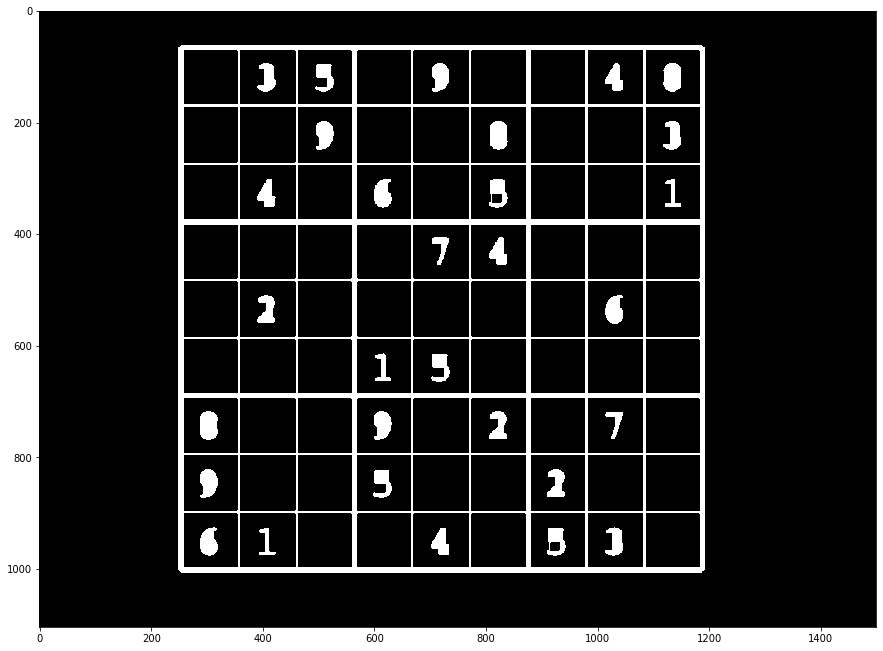

In [6]:
plt.figure(figsize=(15, 15))
plt.imshow(binary_image, cmap='gray')
plt.show()

In [7]:
_, contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [8]:
def is_convex(pts):
    """ 凸多角形かどうかの判定 """
    pts = np.asarray(pts).reshape((-1, 2))
    n = len(pts)
    sign = 0
    for i in range(n):
        pre = (i - 1 + n) % n
        pst = (i + 1) % n
        e1 = pts[pre] - pts[i]
        e2 = pts[pst] - pts[i]
        det = e1[0] * e2[1] - e1[1] * e2[0]
        if sign == 0:
            sign = 1 if det >= 0 else -1
        else:
            if sign * det < 0:
                return False
            
    return True

In [9]:
font = cv2.FONT_HERSHEY_DUPLEX

maxlen = 0.0
maxarc = None
result = image.copy()

# 角が4つで一番長い弧を検出する
for cnt in contours:
    arclen = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.01 * arclen, True)
    
    # 四角形で凸なものに限定する
    if maxlen < arclen and len(approx) == 4:
        if is_convex(approx):
            maxlen = arclen
            maxarc = approx
    
cv2.drawContours(result, [maxarc], 0, (255, 0, 0), 2, cv2.LINE_AA)
src_pts = maxarc.reshape((-1, 2))
for p in src_pts:
    cv2.circle(p, (p[0], p[1]), 10, (0, 0, 255), -1)

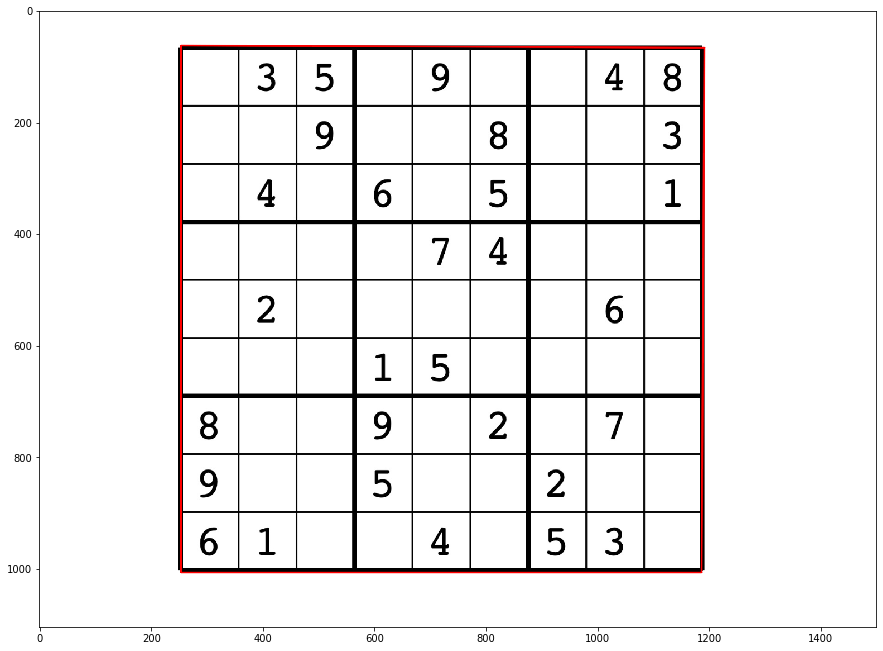

In [10]:
plt.figure(figsize=(15, 15))
plt.imshow(result)
plt.show()

## ホモグラフィー変換で数独を取り出す

In [11]:
# 点の順序を入れ替える
center = np.mean(src_pts, axis=1)

pts = []
for p in src_pts:
    dx = center[0] - p[0]
    dy = center[1] - p[1]
    theta = np.arctan2(dy, dx) + np.pi
    pts.append((theta, p))

pts = sorted(pts, key=lambda p: p[0])
pts = [p[1] for p in pts]

# ホモグラフィー変換行列の計算
src_pts = np.asarray(pts, dtype='float32')
dst_pts = np.asarray([[900, 900], [0, 900], [0, 0], [900, 0]], dtype='float32')
homography = cv2.getPerspectiveTransform(src_pts, dst_pts)

In [12]:
sudoku = cv2.warpPerspective(gray, homography, (900, 900))
sudoku = cv2.adaptiveThreshold(sudoku, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 11)

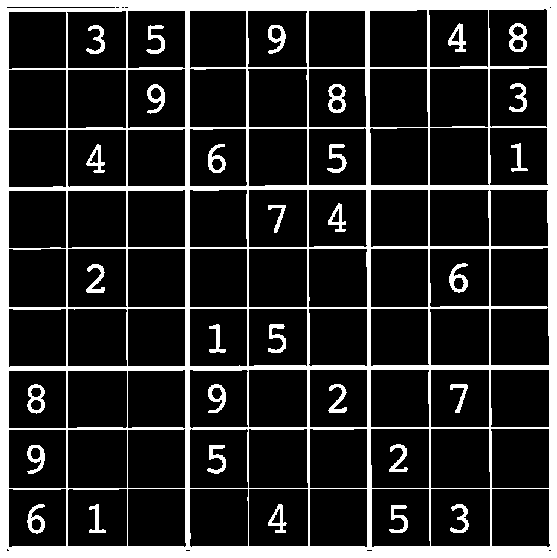

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(sudoku, cmap='gray')
plt.axis('off')
plt.show()

In [14]:
cells = []
for i in range(9):
    for j in range(9):
        xs = j * 100 + 15
        xe = (j + 1) * 100 - 15
        ys = i * 100 + 15
        ye = (i + 1) * 100 - 15
        cell = sudoku[ys:ye, xs:xe]

        # 文字をセンタリングする
        iy, ix = np.where(cell > 128)
        if ix.size > 0 and iy.size > 0:   
            xmin = np.min(ix)
            xmax = np.max(ix)
            ymin = np.min(iy)
            ymax = np.max(iy)
            cx = (xmin + xmax) // 2
            cy = (ymin + ymax) // 2

            h, w = cell.shape
            dx = w // 2 - cx
            dy = h // 2 - cy
            M = np.array([[1.0, 0.0, dx], [0.0, 1.0, dy]])
            cell = cv2.warpAffine(cell, M, (h, w))                
        
        cell = np.pad(cell, (5, 5), mode='constant', constant_values=0)
        cells.append(cell)

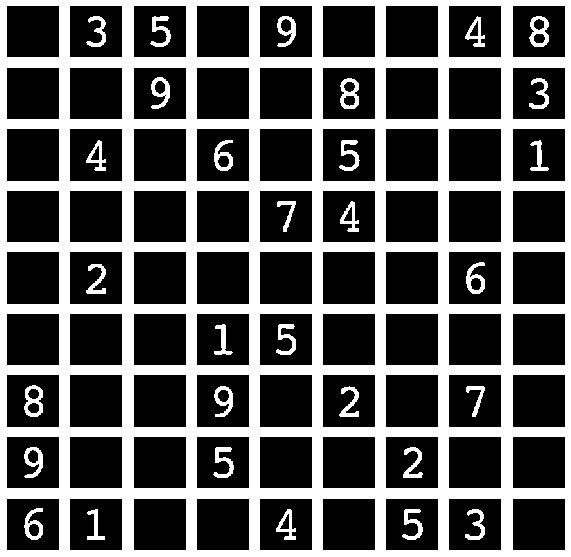

In [15]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    for j in range(9):
        ax = fig.add_subplot(9, 9, i * 9 + j + 1)
        ax.imshow(cells[i * 9 + j], cmap='gray', vmin=0, vmax=255)
        ax.axis('off')
plt.show()

## 学習済みロジスティック回帰による数字の認識

In [16]:
import pickle
with open('model.pickle', 'rb') as f:
    clf = pickle.load(f)

In [17]:
for i in range(9):
    for j in range(9):
        cell = cells[i * 9 + j]
        ratio = np.count_nonzero(cell > 128) / cell.size
        if ratio > 0.05:
            cell = cv2.resize(cell, (28, 28))
            cell = cell.reshape((1, -1))
            label = clf.predict(cell)[0]
            print(label, end='')
        else:
            print('-', end='')
    print()

-35-9--46
--9--8--3
-4-6-3--1
----76---
-2-----6-
---13----
8--9-2-9-
9--5--2--
61--4-53-


## CNNによる数字の認識

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class Network(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Network, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=5, padding=0, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(800, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        num_batch = x.size()[0]
        h = self.net(x)
        h = h.view(num_batch, -1)
        y = self.fc(h)
        
        return torch.log_softmax(y, dim=1)

In [20]:
net = Network(1, 10)
net.load_state_dict(torch.load('model.pth'))
net.eval();

In [21]:
problem = np.zeros((9, 9), dtype='int32')
for i in range(9):
    for j in range(9):
        cell = cells[i * 9 + j]
        ratio = np.count_nonzero(cell > 128) / cell.size
        if ratio > 0.05:
            cell = cv2.resize(cell, (28, 28))
            cell = cell.reshape((1, 1, 28, 28))
            cell = (cell / 255.0).astype('float32')
            cell = torch.from_numpy(cell)
            label = net(cell).argmax(dim=1).item()
            problem[i, j] = label
            print(label, end='')
        else:
            print('-', end='')
    print()

-35-9--48
--9--8--3
-4-6-5--1
----74---
-2-----6-
---15----
8--9-2-7-
9--5--2--
61--4-53-


## Tesseractによる文字認識

In [22]:
import pytesseract
from PIL import Image

In [23]:
config = '--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'

for i in range(9):
    for j in range(9):
        cell = 255 - cells[i * 9 + j]
        
        ratio = np.count_nonzero(cell < 128) / cell.size
        if ratio > 0.05:
            text = pytesseract.image_to_string(Image.fromarray(cell), lang='eng', config=config)
    
            if text == '':
                print('x', end='')
            else:
                print(text, end='')
        else:
            print('-', end='')
            
    print('')

-35-9--48
--9--8--3
-4-6-5--1
----74---
-2-----6-
---15----
8--9-2-7-
9--5--2--
61--4-53-


## 数独を解く

In [24]:
def sudoku_solve(problem):
    rows, cols = problem.shape
    nums = set([i for i in range(0, 10)])
    for i in range(rows):
        for j in range(cols):
            if problem[i, j] == 0:
                k = i // 3
                l = j // 3
                row_nums = problem[i, :].tolist()
                col_nums = problem[:, j].tolist()
                blk_nums = problem[3*k:3*k+3, 3*l:3*l+3].reshape(-1).tolist()
                used = set(row_nums + col_nums + blk_nums)
                diff = nums.difference(used)
                if len(diff) == 0:
                    return False
                
                success = False
                for n in diff:
                    problem[i, j] = n
                    if sudoku_solve(problem):
                        success = True
                        break

                    problem[i, j] = 0

                if not success:
                    return False
        
    return True

In [25]:
answer = problem.copy()
if sudoku_solve(answer):
    print(answer)

[[2 3 5 7 9 1 6 4 8]
 [1 6 9 4 2 8 7 5 3]
 [7 4 8 6 3 5 9 2 1]
 [3 9 6 2 7 4 8 1 5]
 [5 2 1 3 8 9 4 6 7]
 [4 8 7 1 5 6 3 9 2]
 [8 5 3 9 6 2 1 7 4]
 [9 7 4 5 1 3 2 8 6]
 [6 1 2 8 4 7 5 3 9]]


In [26]:
overlay = np.zeros((900, 900, 4), dtype='float32')
font = cv2.FONT_HERSHEY_PLAIN
for i in range(9):
    for j in range(9):
        if problem[i, j] == 0:
            x = j * 100 + 20
            y = i * 100 + 100 - 20
            cv2.putText(overlay, str(answer[i, j]), (x, y), font, 5.0, (1, 0, 0, 1), 5, cv2.LINE_AA)

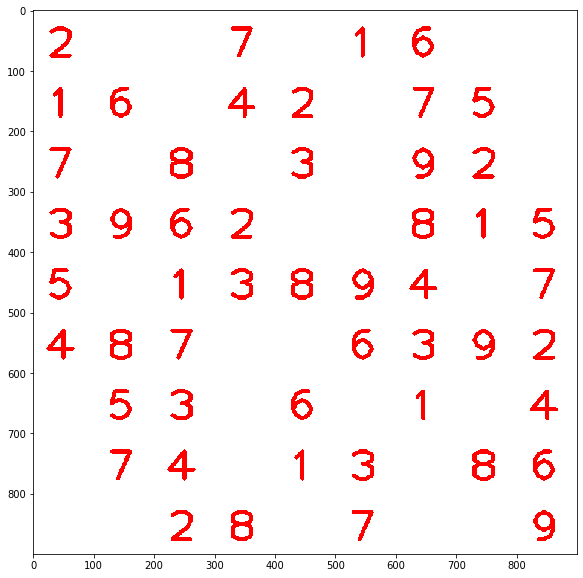

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.show()

In [28]:
warp_numbers = cv2.warpPerspective(overlay, np.linalg.inv(homography), (width, height))
print(image.shape, warp_numbers.shape, width, height)

(1104, 1500, 3) (1104, 1500, 4) 1500 1104


In [29]:
alpha = warp_numbers[:, :, 3:4]
rgb = warp_numbers[:, :, :3]
res = (1.0 - alpha) * (image / 255.0).astype('float32') + alpha * rgb

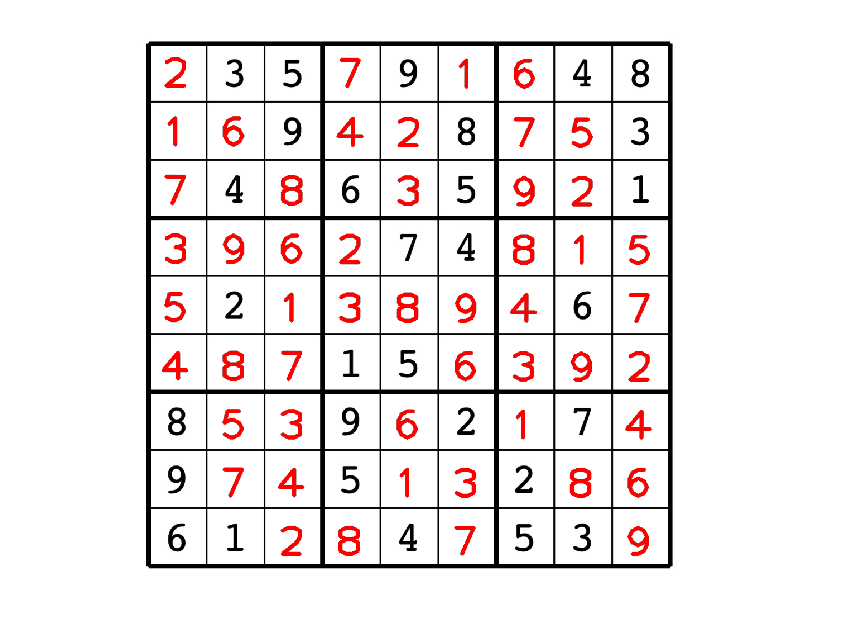

In [30]:
plt.figure(figsize=(15, 15))
plt.imshow(res)
plt.axis('off')
plt.show()

In [31]:
base, ext = os.path.splitext(filename)
outfile = base + '_ans' + ext
cv2.imwrite(base + '_ans' + ext, cv2.cvtColor(res, cv2.COLOR_BGR2RGB) * 255.0)

True